<a href="https://colab.research.google.com/github/sinood/cs194-26_proj4_p3/blob/master/Neural_Style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [121]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
import skimage.io as skio
import datetime
import cv2
import scipy.stats as st
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import copy

DEVICE = torch.device("cuda")
# device = torch.device("cpu")
SIZE = 512
WH_RATIO = 1.3
PATH = '/content/drive/MyDrive/cs194-26_finalproj_ims/'
# PATH = '/content/'

Loss functions

In [3]:


def get_gram_mat(input):
    batchsize, num_features, feature_rows, feature_cols = input.size()
    features = input.view(batchsize*num_features, feature_rows*feature_cols)
    gram_mat = torch.mm(features, features.t())
    gram_mat.div(batchsize*num_features*feature_rows*feature_cols)
    return gram_mat

class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        G.div_(h*w)
        return G

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = GramMatrix()(target_feature).detach()

    def forward(self, input):
        # gram_mat = get_gram_mat(input)
        # self.loss = nn.MSELoss()gram_mat
        self.loss = nn.MSELoss()(GramMatrix()(input), self.target)
        # self.loss = F.mse_loss(gram_mat, self.target)
        return input

class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, im):
        return (im - self.mean) / self.std

def insert_loss_layers(model, im_content, im_style,
                content_loss_layers=['conv_11'],
                style_loss_layers=['conv_2', 'conv_4', 'conv_6','conv_10', 'conv_13']):
    model = copy.deepcopy(model)
    normalize = Normalize(mean=torch.tensor([0.485, 0.456, 0.406]).to(DEVICE),
                          std=torch.tensor([0.229, 0.224, 0.225]).to(DEVICE))
    new_model = nn.Sequential(normalize)

    losses_content = []
    losses_style = []
    i = 0
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
            # Change max pool layers to avg pool
            layer = nn.AvgPool2d(kernel_size=2, stride=2)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        new_model.add_module(name, layer)

        if name in content_loss_layers:
            target = new_model(im_content).detach()
            content_loss = ContentLoss(target)
            new_model.add_module("content_{}".format(i), content_loss)
            losses_content.append(content_loss)

        if name in style_loss_layers:
            target_feature = new_model(im_style).detach()
            style_loss = StyleLoss(target_feature)
            new_model.add_module("style_{}".format(i), style_loss)
            losses_style.append(style_loss)

    # Don't want the remaining layers, just the loss layers we added, so clip the rest
    last_layer = i
    for j in range(len(new_model)-1,-1,-1):
        if isinstance(new_model[i], ContentLoss) or isinstance(new_model[i], StyleLoss):
            last_layer = j
            break
    new_model = new_model[:last_layer+1]

    return new_model, losses_content, losses_style
  
def transfer(model_pre, im_content, im_style, input, iters=500, weight_style=[1e6/n**2 for n in [64,128,256,512,512]], weight_content=1):
    t0 = datetime.datetime.now()
    print('Creating model')
    model, content_losses, style_losses = insert_loss_layers(model_pre, im_content, im_style)
    print(model)
    optimizer = optim.LBFGS([input.requires_grad_()])
    t1 = datetime.datetime.now()
    print('Model creation: {}'.format(t1-t0))
    print('Running optimization loop')
    iter_num = 0
    style_loss_failed = 0
    total_style_loss_tries = 0
    while iter_num <= iters:

        def combined_loss():
            nonlocal iter_num, total_style_loss_tries, style_loss_failed
            input.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input)
            loss_c = 0
            loss_s = 0
            for l in content_losses:
              loss_c = loss_c + l.loss
            for i in range(len(style_losses)):
                l = style_losses[i]
                w = weight_style[i]
                total_style_loss_tries = total_style_loss_tries + 1
                try:
                    loss_s = loss_s + l.loss*w
                except:
                    style_loss_failed = style_loss_failed + 1
            loss = loss_s + loss_c*weight_content
            # print(len(content_losses), len(style_losses))
            loss.backward()
            iter_num += 1
            if iter_num % 50 == 0:
                print('{} content: {:3f} style: {:3f}'.format(iter_num,
                    loss_c.item(), loss_s.item()))
            return loss_s + loss_c

        optimizer.step(combined_loss)
    input.data.clamp_(0, 1)
    t2 = datetime.datetime.now()
    print('Style loss failed {} out of {} times'.format(style_loss_failed, total_style_loss_tries))
    print('Total time: {}'.format(t2-t1))
    return input



In [4]:
model = models.vgg19(pretrained=True).features
model = model.to(DEVICE)
model = model.eval()


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


Image loading 

In [122]:
# Need to make images same size and convert them to tensors
im_adjust = transforms.Compose([
    transforms.Resize((SIZE,int(SIZE*WH_RATIO))),
    transforms.ToTensor()])
im_convert = transforms.ToPILImage()

def imload(imname):
    im = Image.open(imname)
    im = im_adjust(im)
    im = im.unsqueeze(0)
    return im.to(DEVICE, torch.float)

def display_tensor_im(im_tensor):
    plt.figure()
    im = im_tensor.cpu().clone()
    im = im_convert(im.squeeze(0))
    plt.imshow(im)
  
def imsave(im_tensor, folder, imname):
    im = im_tensor.cpu().clone()
    im = im_convert(im.squeeze(0))
    im.save(os.path.join(folder, imname))
    # skio.imsave(os.path.join(folder, imname), im)





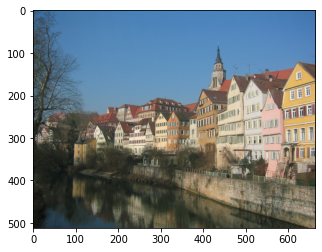

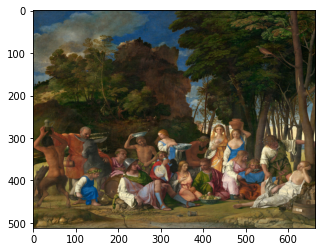

In [219]:
content_im = imload(PATH+'neckarfront.jpg')
style_im = imload(PATH+'bellini2.jpg')
display_tensor_im(content_im)
display_tensor_im(style_im)

Creating model
Sequential(
  (0): Normalize()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_4): StyleLoss()
  (relu_4): ReLU()
  (pool_4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_5): ReLU()
  (conv_6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_6): StyleLoss()
  (relu_6): ReLU()
  (conv_7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_7): ReLU()
  (conv_8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


50 content: 3.791359 style: 57.920818
100 content: 3.314368 style: 23.664598
150 content: 2.998071 style: 11.277656
200 content: 2.794384 style: 5.058052
250 content: 2.611353 style: 2.340694
300 content: 2.413513 style: 1.276531
350 content: 2.263361 style: 0.841702
400 content: 2.154688 style: 0.646306
450 content: 2.070088 style: 0.542074
500 content: 2.007827 style: 0.481332
Style loss failed 0 out of 2600 times
Total time: 0:01:37.754940


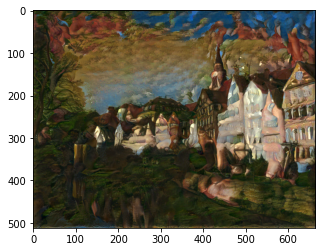

In [220]:
# input = torch.randn(content_im.data.size(), device=DEVICE) # White noise img
input = content_im.clone()
# output = transfer(model, content_im, style_im, input)
output = transfer(model, content_im, style_im, input, weight_style=[8e6/n**2 for n in [64,128,256,512,512]], weight_content=1)

display_tensor_im(output)
imsave(output,'/content/drive/MyDrive/cs194-26_finalproj_ims/out', 'out9_5.jpg')
plt.show()

Example 2:

In [20]:
imsave(output,'/content/drive/MyDrive/cs194-26_finalproj_ims/out', 'out1.jpg')
# print(loss_style)